In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import os
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image

In [ ]:
# Define the path to your dataset
data_dir = 'Vehicle_Dataset'

# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 2
# Create data generators for training and validation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Display the classes
class_names = sorted(os.listdir(os.path.join(data_dir)))
print("Classes:", class_names)

Found 147 images belonging to 3 classes.
Found 36 images belonging to 3 classes.
Classes: ['Sedan', 'Truck', 'Van']


In [ ]:
# Load the ResNet50 model with pre-trained weights (excluding top fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data=validation_generator
)

Epoch 1/10
74/74 [==============================] - 190s 2s/step - loss: 1.9706 - accuracy: 0.4558 - val_loss: 1.5117 - val_accuracy: 0.2778
Epoch 2/10
74/74 [==============================] - 158s 2s/step - loss: 1.1224 - accuracy: 0.4218 - val_loss: 1.3517 - val_accuracy: 0.4444
Epoch 3/10
74/74 [==============================] - 154s 2s/step - loss: 1.0954 - accuracy: 0.4354 - val_loss: 1.9143 - val_accuracy: 0.4444
Epoch 4/10
74/74 [==============================] - 184s 2s/step - loss: 1.0891 - accuracy: 0.4150 - val_loss: 4.3641 - val_accuracy: 0.4444
Epoch 5/10
74/74 [==============================] - 177s 2s/step - loss: 1.0660 - accuracy: 0.4490 - val_loss: 1.5672 - val_accuracy: 0.4444
Epoch 6/10
74/74 [==============================] - 154s 2s/step - loss: 1.0356 - accuracy: 0.4898 - val_loss: 7.2517 - val_accuracy: 0.4444
Epoch 7/10
74/74 [==============================] - 171s 2s/step - loss: 1.0559 - accuracy: 0.4966 - val_loss: 3.4128 - val_accuracy: 0.2778
Epoch 8/10
74

In [ ]:
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Using the validation subset for testing
    shuffle=False  # Important: Do not shuffle the testing dataset
)

# Evaluate the model on the testing dataset
evaluation = model.evaluate(test_generator)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

# Make predictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes  # True labels of the testing dataset

# Calculate classification metrics
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)

confusion = confusion_matrix(true_labels, predicted_labels)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion)

Found 36 images belonging to 3 classes.
18/18 [==============================] - 7s 370ms/step - loss: 1.0526 - accuracy: 0.4722
Test Loss: 1.052592396736145
Test Accuracy: 0.4722222089767456
18/18 [==============================] - 9s 335ms/step
Classification Report:
               precision    recall  f1-score   support

       Sedan       0.45      0.94      0.61        16
       Truck       0.67      0.20      0.31        10
         Van       0.00      0.00      0.00        10

    accuracy                           0.47        36
   macro avg       0.37      0.38      0.31        36
weighted avg       0.39      0.47      0.36        36

Confusion Matrix:
 [[15  1  0]
 [ 8  2  0]
 [10  0  0]]


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

In [ ]:
def predict_image(image_array):
    prediction = model.predict(image_array)
    class_index = np.argmax(prediction)
    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[class_index]
    confidence = prediction[0][class_index] # Confidence score for the predicted class
    return predicted_label, confidence

In [ ]:
def display_prediction(image_path):
    preprocessed_image = preprocess_image(image_path)
    predicted_label, confidence = predict_image(preprocessed_image)
    plt.imshow(preprocessed_image[0])
    plt.title(f'Predicted: {predicted_label}')
    plt.show()

1/1 [==============================] - 3s 3s/step


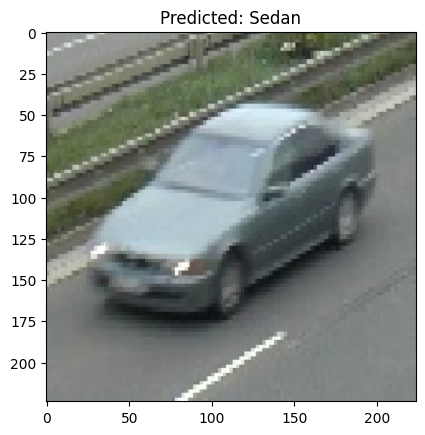

In [ ]:
# Provide the path to your test image
test_image_path = 'Vehicle_Dataset/test_image.jpg'
display_prediction(test_image_path)

1/1 [==============================] - 0s 298ms/step


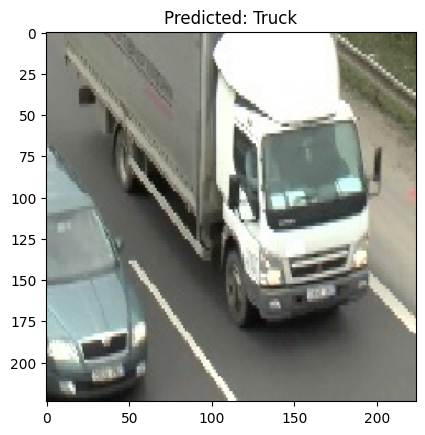

In [ ]:
test_image_path = 'Vehicle_Dataset/test_image2.jpg'
display_prediction(test_image_path)